## Data Pre-processing

In [1]:
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE

# Step 0: Load and Clean Data
data = pd.read_csv('combined_dataset_3.csv')
target_column = 'insider_y'

# Print original target distribution (including NaNs)
print("Original class distribution (including NaNs):", Counter(data[target_column]))

data_clean = data.dropna(subset=[target_column]).copy()

# Convert the target to numeric 
data_clean.loc[:, target_column] = pd.to_numeric(data_clean[target_column], errors='coerce')

# Print class distribution after dropping NaNs
print("Class distribution after dropping NaNs:", Counter(data_clean[target_column]))

# Step 1: Separate Features and Target
removed_cols = ['user', 'day', 'week', 'starttime', 'endtime', 'sessionid', target_column]

# Only drop the columns that are actually in the DataFrame.
cols_to_drop = [col for col in removed_cols if col in data_clean.columns]
print("Dropping columns:", cols_to_drop)

# Separate features (X) and target (y)
X = data_clean.drop(columns=cols_to_drop)
y = data_clean[target_column]

# Step 2: Apply SMOTE Oversampling
print("Cleaned target distribution:", Counter(y))

# Create an instance of SMOTE to balance the dataset.
sm = SMOTE(random_state=42, sampling_strategy='auto')
X_res, y_res = sm.fit_resample(X, y)

print("Resampled target distribution:", Counter(y_res))

# Step 3: Combine Back into a DataFrame and Save
df_resampled = X_res.copy()
df_resampled[target_column] = y_res

output_filename = 'SMOTE_dataset.csv'
df_resampled.to_csv(output_filename, index=False)
print("Resampled dataset saved as", output_filename)

Original class distribution (including NaNs): Counter({0.0: 139572, 4.0: 248, 2.0: 245, 1.0: 49, 3.0: 10, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1

In [5]:
import pandas as pd

def count_binary_values(file_path, column_name):
    
    df = pd.read_csv(file_path)
    
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the CSV file.")
    
    # Count occurrences of 0 and 1 in the specified column
    counts = df[column_name].value_counts()
    ones = counts.get(1, 0)
    zeros = counts.get(0, 0)
    
    return ones, zeros

if __name__ == "__main__":
    file_path = 'SMOTE_dataset.csv'
    binary_column = 'insider_y'
    
    try:
        ones, zeros = count_binary_values(file_path, binary_column)
        print(f"Number of 1s in column '{binary_column}': {ones}")
        print(f"Number of 0s in column '{binary_column}': {zeros}")
    except Exception as e:
        print("Error:", e)

Number of 1s in column 'insider_y': 139572
Number of 0s in column 'insider_y': 139572


## MODEL TRAINING

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
import requests
import json
import time
import os
from IPython.display import display, Markdown
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
# Function to load data from a CSV file
def load_data(file_path, label_column='insider_y'):
    """
    Loads data from the CSV file and separates features from the label.
    Assumes that identifier columns such as starttime, endtime, user, day, and week are not needed.
    """
    df = pd.read_csv(file_path)
    # Drop identifier columns if present
    drop_cols = ['starttime', 'endtime', 'user', 'day', 'week']
    cols_to_drop = [col for col in drop_cols if col in df.columns]
    X = df.drop(columns=cols_to_drop + [label_column]).values
    y = df[label_column].values
    return X, y

train_file = 'train_SMOTEr5.2.csv'
test_file  = 'test_SMOTEr5.2.csv'

# Load the data
X_train, y_train = load_data(train_file, label_column='insider_y')
X_test, y_test   = load_data(test_file, label_column='insider_y')

# Standardize features for better training stability
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Reshape X to (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define input shape for the model: (timesteps, num_features)
input_shape = (X_train.shape[1], X_train.shape[2])  # For example, (1, num_features)

# Build the LSTM-CNN model according to the paper's framework
input_layer = Input(shape=input_shape)

# --- LSTM Feature Extraction ---
# First LSTM layer with 60 units
lstm_out = LSTM(60, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)
# Second LSTM layer with 40 units
lstm_out = LSTM(40, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
# Third LSTM layer with 20 units
lstm_out = LSTM(20, return_sequences=True)(lstm_out)

# --- CNN Classification ---
conv_out = Conv1D(filters=32, kernel_size=1, activation='tanh')(lstm_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out)  # With sequence length 1, pooling is trivial
conv_out = BatchNormalization()(conv_out)
conv_out = Conv1D(filters=64, kernel_size=1, activation='tanh')(conv_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out)
conv_out = BatchNormalization()(conv_out)
conv_out = Flatten()(conv_out)

dense_out = Dense(64, activation='tanh')(conv_out)
dense_out = Dropout(0.5)(dense_out)
output_layer = Dense(2, activation='softmax')(dense_out)  # 2 classes: normal (0) and malicious (1)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- Model Training ---
# Train the model using only the train dataset
history = model.fit(X_train, y_train,
                    epochs=10,       
                    batch_size=20)

# --- Model Evaluation ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 2138)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 60)          │       527,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 40)          │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 20)          │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 32)          │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 556,258 (2.12 MB)

 Trainable params: 556,066 (2.12 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
11166/11166 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9973 - loss: 0.0085
Epoch 2/10
11166/11166 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9998 - loss: 9.0531e-04
Epoch 3/10
11166/11166 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9999 - loss: 9.0276e-04
Epoch 4/10
11166/11166 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9999 - loss: 5.9637e-04
Epoch 5/10
11166/11166 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9999 - loss: 3.8657e-04
Epoch 6/10
11166/11166 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9999 - loss: 2.4724e-04
Epoch 7/10
11166/11166 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 1.0000 - loss: 3.2721e-04
Epoch 8/10
11166/11166 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9999 - loss: 6.3820e-04
Epoch 9/10
11166/11166 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9999 - loss: 8.1324e-04
Epoch 10/10
11166/11166 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9999 - loss: 5.1525e-04
Test Loss: 0.0000, Test Accuracy: 1.0000


## SHAP Evaluation

X_train shape: (223314, 1, 2138)
X_test shape: (55830, 1, 2138)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Number of malicious (insider==1) samples in X_test: 27915
X_sample_flat shape (only malicious samples): (100, 2138)


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 432us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 408us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 406us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 405us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 410us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 402us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 402us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 409us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 411us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 407us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 410us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14269/14269 ━━━━━━━━━━━━━━━━━━━━ 6s 4

/var/folders/gf/94pg_58917947pd7kbsg5d6m0000gn/T/ipykernel_32235/1123659515.py:64: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(final_shap, X_sample_flat, feature_names=feature_names)


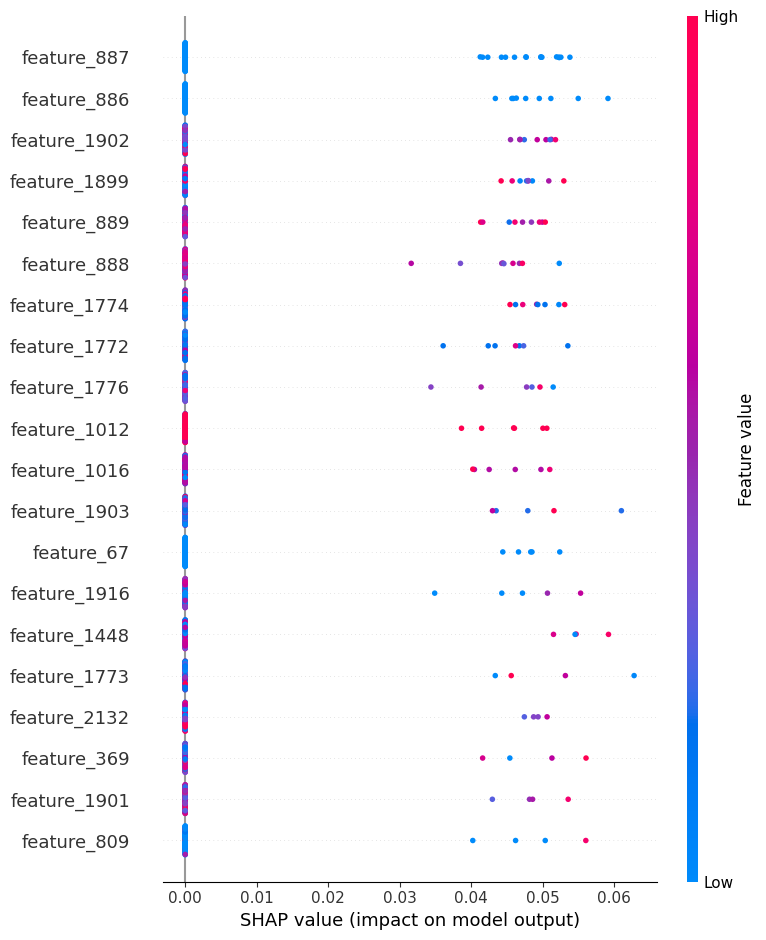

In [5]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


# Step 1: Prepare background data (flattened)
# Flatten training data from (samples, 1, 2138) to (samples, 2138)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

np.random.seed(42)
background_size = 100
background_indices = np.random.choice(X_train_flat.shape[0], background_size, replace=False)
background_data = X_train_flat[background_indices]


# Step 2: Define prediction function for flattened input
def model_predict_flat(x_flat):
    # x_flat has shape (samples, 2138)
    x_reshaped = x_flat.reshape(x_flat.shape[0], 1, x_flat.shape[1])
    preds = model.predict(x_reshaped)  # Expected shape: (samples, num_outputs)
    return preds


# Step 3: Initialize the KernelExplainer using the flattened background data
explainer = shap.KernelExplainer(model_predict_flat, background_data)


# Step 4: Prepare samples from X_test that have insider == 1 and flatten them.
insider_indices = np.where(y_test == 1)[0]
print("Number of malicious (insider==1) samples in X_test:", len(insider_indices))
X_test_insider = X_test[insider_indices]

# Randomly select 100 samples from the insider samples.
num_samples = 100
if X_test_insider.shape[0] < num_samples:
    num_samples = X_test_insider.shape[0]
selected_indices = np.random.choice(X_test_insider.shape[0], num_samples, replace=False)
X_sample = X_test_insider[selected_indices]
X_sample_flat = X_sample.reshape(num_samples, -1)
print("X_sample_flat shape (only malicious samples):", X_sample_flat.shape)


# Step 5: Compute SHAP values for these samples
# KernelExplainer returns a list with one array per sample.
shap_values = explainer.shap_values(X_sample_flat)
for i, sv in enumerate(shap_values):
    print(f"Shape of SHAP values for sample {i}:", sv.shape)
# According to output, each sample gives shape (2138, 2)


# Step 6: Stack the list into a single array and select contributions for a chosen class.
# Stack the list of arrays along the first dimension. The resulting array will have shape (num_samples, 2138, 2)
shap_values_arr = np.stack(shap_values, axis=0)
print("Stacked SHAP values shape:", shap_values_arr.shape)

# To explain class index 1 (malicious), extract those contributions:
final_shap = shap_values_arr[:, :, 1]  # shape becomes (num_samples, 2138)
print("Final SHAP array for class 1 shape:", final_shap.shape)


# Step 7: Visualization using the SHAP summary (beeswarm) plot.
num_features = X_sample_flat.shape[1]  # should be 2138
feature_names = [f"feature_{i}" for i in range(num_features)]
shap.summary_plot(final_shap, X_sample_flat, feature_names=feature_names)

## Permutation Feature Importance

Calculating permutation importance with focus on malicious class detection...
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step
Baseline AUC score: 1.0000
Feature set is large (2138 features). Selecting top 100 by variance...
Selected 100 features
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step
Processed 0/100 features
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step
1745/1745 ━━

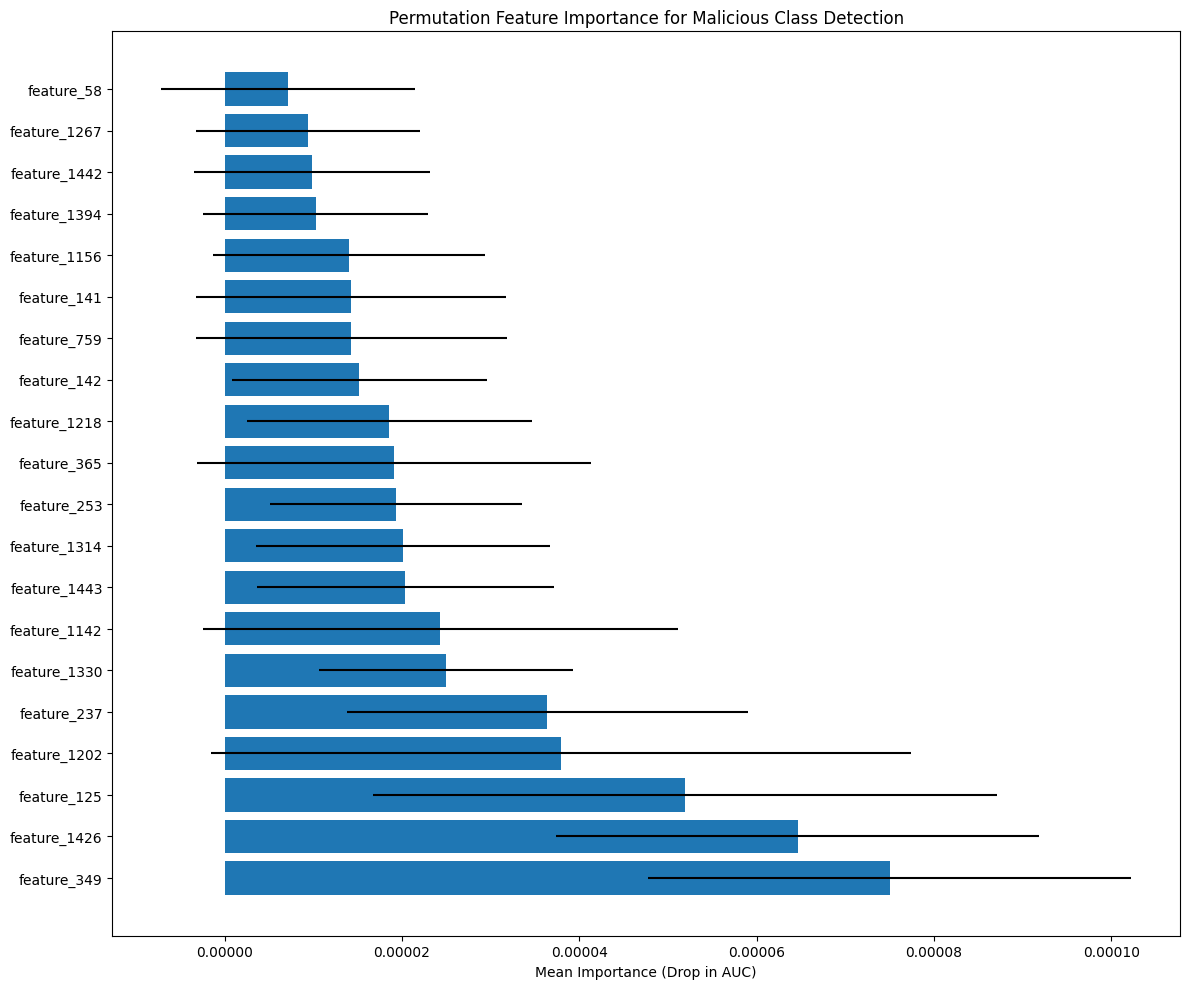


Top 20 features by SHAP importance for malicious class:
1. feature_887 (SHAP value: 0.0077)
2. feature_886 (SHAP value: 0.0044)
3. feature_1902 (SHAP value: 0.0044)
4. feature_1899 (SHAP value: 0.0043)
5. feature_889 (SHAP value: 0.0042)
6. feature_888 (SHAP value: 0.0040)
7. feature_1774 (SHAP value: 0.0039)
8. feature_1772 (SHAP value: 0.0032)
9. feature_1776 (SHAP value: 0.0027)
10. feature_1012 (SHAP value: 0.0027)
11. feature_1016 (SHAP value: 0.0027)
12. feature_1903 (SHAP value: 0.0025)
13. feature_67 (SHAP value: 0.0024)
14. feature_1916 (SHAP value: 0.0023)
15. feature_1448 (SHAP value: 0.0022)
16. feature_1773 (SHAP value: 0.0020)
17. feature_2132 (SHAP value: 0.0020)
18. feature_369 (SHAP value: 0.0019)
19. feature_1901 (SHAP value: 0.0019)
20. feature_809 (SHAP value: 0.0019)

Features in common between Permutation Importance and SHAP: 0


In [6]:
# 1. Create a proper scikit-learn compatible wrapper for the Keras model
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        X_reshaped = X.reshape(X.shape[0], 1, X.shape[1] // 1)
        return self.model.predict(X_reshaped)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_malicious_proba(self, X):
        """Returns the probability of being malicious (class 1)"""
        return self.predict_proba(X)[:, 1]
    
    def score(self, X, y):
        # Instead of accuracy, use AUC (focusing more on malicious class)
        y_score = self.predict_malicious_proba(X)
        return roc_auc_score(y, y_score)

# 2. Flatten the test data 
X_test_flat = X_test.reshape(X_test.shape[0], -1)


wrapped_model = KerasModelWrapper(model)

# 4. Custom permutation importance focusing on malicious class detection
def malicious_class_permutation_importance(model, X, y, n_repeats=10, random_state=None):
    """
    Custom implementation of permutation importance focused on malicious class detection.
    
    Args:
        model: A fitted model with predict_proba method
        X: Feature matrix
        y: Target vector
        n_repeats: Number of times to permute each feature
        random_state: Random seed for reproducibility
        
    Returns:
        Dictionary with importance scores
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Calculate baseline AUC score (focusing on malicious class)
    baseline_score = model.score(X, y)
    print(f"Baseline AUC score: {baseline_score:.4f}")
    
    n_samples, n_features = X.shape
    importances = np.zeros((n_features, n_repeats))
    
    # For very large feature sets, limit to top 100 features by variance
    if n_features > 100:
        print(f"Feature set is large ({n_features} features). Selecting top 100 by variance...")
        variances = np.var(X, axis=0)
        top_features = np.argsort(-variances)[:100]
        selected_features = top_features
        print(f"Selected {len(selected_features)} features")
    else:
        selected_features = range(n_features)
    
    # For each feature, permute its values and calculate the drop in AUC score
    for idx, feature_idx in enumerate(selected_features):
        for rep in range(n_repeats):
            X_permuted = X.copy()
            permutation = np.random.permutation(n_samples)
            X_permuted[:, feature_idx] = X_permuted[permutation, feature_idx]
            
            # Calculate new AUC score (focusing on malicious class)
            new_score = model.score(X_permuted, y)
            importances[feature_idx, rep] = baseline_score - new_score
            
        # Print progress for larger feature sets
        if len(selected_features) > 20 and idx % 10 == 0:
            print(f"Processed {idx}/{len(selected_features)} features")
    
    # Calculate mean and std of importance scores
    importance_mean = np.mean(importances, axis=1)
    importance_std = np.std(importances, axis=1)
    
    return {
        'importances_mean': importance_mean,
        'importances_std': importance_std,
        'selected_features': selected_features,
        'baseline_score': baseline_score
    }

# 5. Run custom permutation importance
print("Calculating permutation importance with focus on malicious class detection...")

result = malicious_class_permutation_importance(
    wrapped_model, 
    X_test_flat, 
    y_test, 
    n_repeats=5,  # Reduce repeats to speed up
    random_state=42
)

# 6. Get feature names
num_features = X_test_flat.shape[1]
feature_names = [f"feature_{i}" for i in range(num_features)]

# 7. Create a DataFrame for the results
importance_data = {
    'feature': feature_names,
    'importance': result['importances_mean'],
    'std': result['importances_std']
}
perm_importance_df = pd.DataFrame(importance_data)

# 8. Sort by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# 9. Print top 20 most important features for malicious class detection
print("\nTop 20 features by permutation importance (focusing on malicious class detection):")
print(perm_importance_df.head(20))

# 10. Plot the top 20 features
plt.figure(figsize=(12, 10))
top_20 = perm_importance_df.head(20)
plt.barh(np.arange(len(top_20)), top_20['importance'], xerr=top_20['std'])
plt.yticks(np.arange(len(top_20)), top_20['feature'])
plt.xlabel('Mean Importance (Drop in AUC)')
plt.title('Permutation Feature Importance for Malicious Class Detection')
plt.tight_layout()
plt.show()


# 12. Compare with SHAP importance (if you have SHAP results)
if 'final_shap' in globals():
    # final_shap already contains SHAP values for the malicious class (class 1)
    mean_shap_abs = np.mean(np.abs(final_shap), axis=0)
    top_shap_indices = np.argsort(-mean_shap_abs)[:20]
    shap_top_features = [feature_names[i] for i in top_shap_indices]
    
    # Print top SHAP features
    print("\nTop 20 features by SHAP importance for malicious class:")
    for i, feature in enumerate(shap_top_features):
        print(f"{i+1}. {feature} (SHAP value: {mean_shap_abs[top_shap_indices[i]]:.4f})")
    
    # Find common features between permutation importance and SHAP
    common_features = set(top_20['feature']).intersection(set(shap_top_features))
    print(f"\nFeatures in common between Permutation Importance and SHAP: {len(common_features)}")
    for feature in common_features:
        print(f"- {feature}")

## T-SNE Visualization

Extracting LSTM features for combined(SMOTE) data...
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step 
LSTM features shape: (55830, 20)
Applying t-SNE dimensionality reduction...
Sampled 1000 points for t-SNE (out of 55830)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


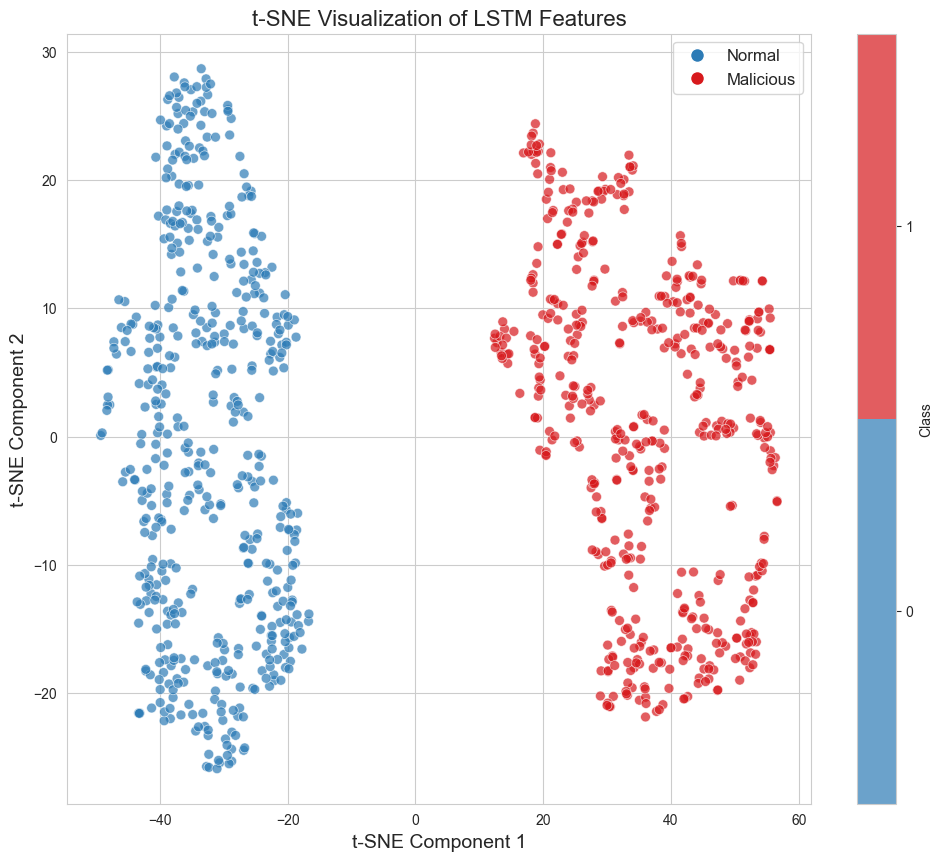

Normal samples: 500, Malicious samples: 500
Distance between normal and malicious centroids: 68.2780
Normal class variance: 279.8224
Malicious class variance: 291.0445


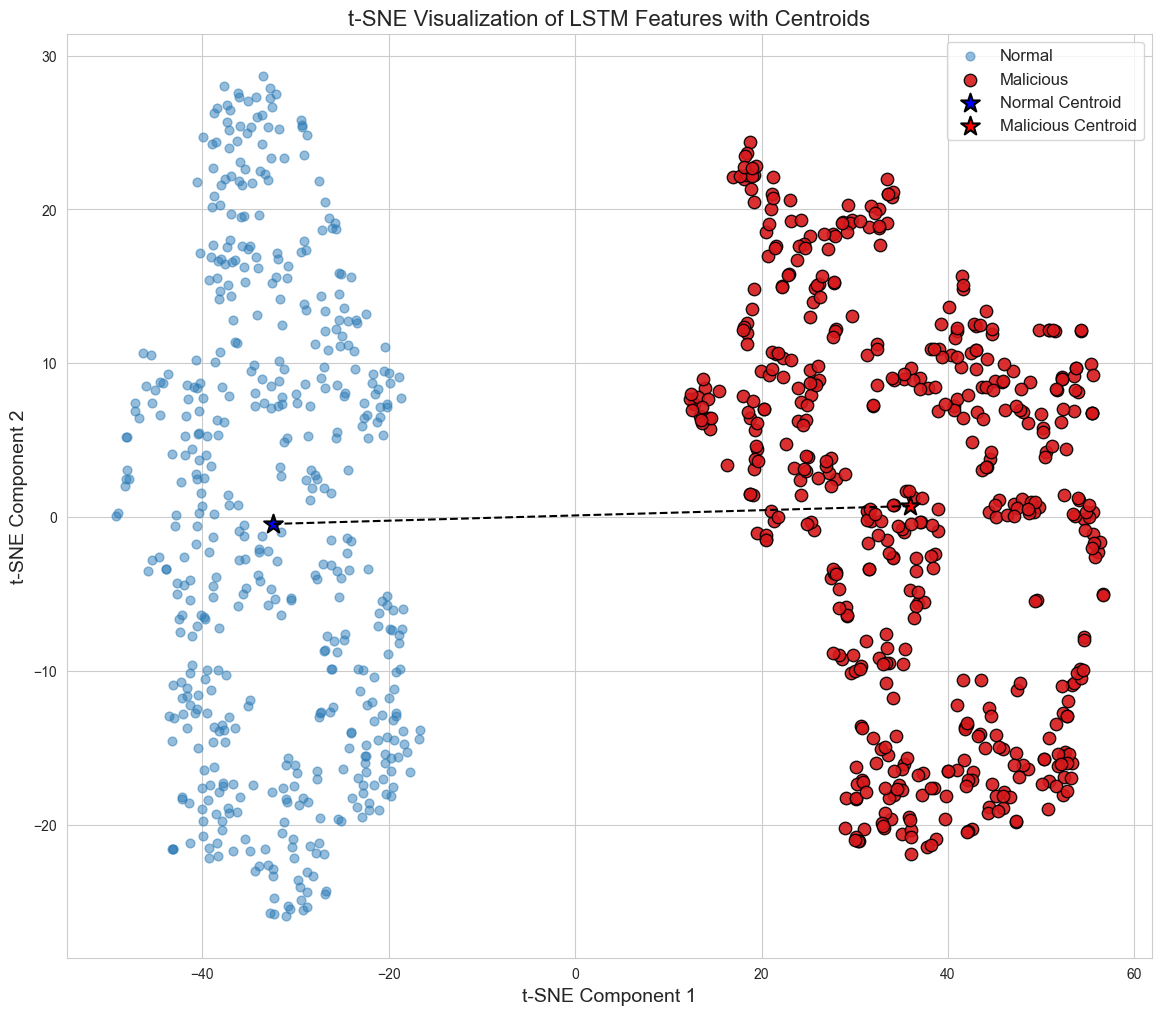

In [8]:
# 1. Flatten the data
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 2. Get LSTM features (if you want to visualize the LSTM features instead of raw features)
def get_lstm_features(model, X):
    """Extract features from the last LSTM layer"""
    from tensorflow.keras.models import Model
    
    lstm_layer_output = model.layers[5].output
    feature_model = Model(inputs=model.input, outputs=lstm_layer_output) 

    features = feature_model.predict(X)
    
    features_flat = features.reshape(features.shape[0], -1)
    
    return features_flat

use_lstm_features = True

if use_lstm_features:
    print("Extracting LSTM features for combined(SMOTE) data...")
    features = get_lstm_features(model, X_test)
    print(f"LSTM features shape: {features.shape}")
else:
    features = X_test_flat
    print(f"Using raw features with shape: {features.shape}")

# 3. Apply t-SNE
print("Applying t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate=200)

# Apply t-SNE to all samples
max_samples = 1000
if len(features) > max_samples:
    # Sample without losing the class balance
    n_malicious = sum(y_test == 1)
    n_normal = sum(y_test == 0)
    
    if n_malicious <= max_samples // 2:
        # Keep all malicious samples
        malicious_indices = np.where(y_test == 1)[0]
        # Sample from normal samples
        normal_indices = np.where(y_test == 0)[0]
        normal_sampled = np.random.choice(normal_indices, min(max_samples - n_malicious, n_normal), replace=False)
        # Combine indices
        indices = np.concatenate([malicious_indices, normal_sampled])
    else:
        # Sample equally from both classes
        malicious_indices = np.where(y_test == 1)[0]
        normal_indices = np.where(y_test == 0)[0]
        malicious_sampled = np.random.choice(malicious_indices, max_samples // 2, replace=False)
        normal_sampled = np.random.choice(normal_indices, max_samples // 2, replace=False)
        # Combine indices
        indices = np.concatenate([malicious_sampled, normal_sampled])
    
    # Get the sampled data
    features_sampled = features[indices]
    y_test_sampled = y_test[indices]
    
    print(f"Sampled {len(features_sampled)} points for t-SNE (out of {len(features)})")
    
    # Apply t-SNE to the sampled data
    tsne_results = tsne.fit_transform(features_sampled)
    y_for_plot = y_test_sampled
else:
    # Apply t-SNE to all data
    tsne_results = tsne.fit_transform(features)
    y_for_plot = y_test

# 4. Visualize the t-SNE results
plt.figure(figsize=(12, 10))

# Create a more visually appealing plot
sns.set_style("whitegrid")

# Create a scatter plot with enhanced appearance
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], 
    c=y_for_plot, 
    cmap=ListedColormap(['#2C7BB6', '#D7191C']),  # Blue for normal, Red for malicious
    alpha=0.7,
    s=50,  
    edgecolors='w',  
    linewidth=0.5
)

plt.colorbar(scatter, ticks=[0, 1], label='Class')
plt.clim(-0.5, 1.5)  

# Add labels and title
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
if use_lstm_features:
    plt.title('t-SNE Visualization of LSTM Features', fontsize=16)
else:
    plt.title('t-SNE Visualization of Raw Features', fontsize=16)

# Add a legend
labels = ['Normal', 'Malicious']
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2C7BB6', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#D7191C', markersize=10)
]
plt.legend(handles, labels, fontsize=12, loc='best')
plt.show()

# 5. Analyze the t-SNE results
# Count of normal/malicious samples
normal_count = sum(y_for_plot == 0)
malicious_count = sum(y_for_plot == 1)
print(f"Normal samples: {normal_count}, Malicious samples: {malicious_count}")

# Calculate the centroids for each class
normal_centroid = np.mean(tsne_results[y_for_plot == 0], axis=0)
malicious_centroid = np.mean(tsne_results[y_for_plot == 1], axis=0)

# Calculate the distance between centroids
centroid_distance = np.linalg.norm(normal_centroid - malicious_centroid)
print(f"Distance between normal and malicious centroids: {centroid_distance:.4f}")

# Calculate within-class scatter (variance)
normal_variance = np.mean(np.sum((tsne_results[y_for_plot == 0] - normal_centroid)**2, axis=1))
malicious_variance = np.mean(np.sum((tsne_results[y_for_plot == 1] - malicious_centroid)**2, axis=1))
print(f"Normal class variance: {normal_variance:.4f}")
print(f"Malicious class variance: {malicious_variance:.4f}")

# 6. Enhanced visualization with highlighted malicious samples
plt.figure(figsize=(14, 12))

# First plot the normal samples as a background
plt.scatter(
    tsne_results[y_for_plot == 0, 0], tsne_results[y_for_plot == 0, 1],
    c='#2C7BB6', alpha=0.5, s=40, label='Normal'
)

# Then plot the malicious samples with higher visibility
plt.scatter(
    tsne_results[y_for_plot == 1, 0], tsne_results[y_for_plot == 1, 1],
    c='#D7191C', alpha=0.9, s=80, label='Malicious', 
    edgecolors='black', linewidth=1
)

# Plot the centroids
plt.scatter(
    normal_centroid[0], normal_centroid[1], 
    c='blue', s=200, marker='*', label='Normal Centroid',
    edgecolors='black', linewidth=1.5
)
plt.scatter(
    malicious_centroid[0], malicious_centroid[1], 
    c='red', s=200, marker='*', label='Malicious Centroid',
    edgecolors='black', linewidth=1.5
)

# Add a line connecting the centroids
plt.plot(
    [normal_centroid[0], malicious_centroid[0]],
    [normal_centroid[1], malicious_centroid[1]],
    'k--', linewidth=1.5
)

# Add labels and title
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
feature_type = "LSTM Features" if use_lstm_features else "Raw Features"
plt.title(f't-SNE Visualization of {feature_type} with Centroids', fontsize=16)
plt.legend(fontsize=12)

plt.show()

# 7. Save the t-SNE results for further analysis
tsne_df = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'class': y_for_plot
})